<a href="https://colab.research.google.com/github/jumbokh/nknu-class/blob/main/CNN/notebooks/08_09_Tensorflow_Object_Detection_API_Video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tensorflow Object Detection API 視訊測試

In [ ]:
# 載入套件
import os
import pathlib
import tensorflow as tf
import pathlib

C:\anaconda3\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.3) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


## GPU 記憶體配置設定

In [ ]:
# GPU 設定為 記憶體動態調整 (dynamic memory allocation)
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
#  GPU 設定為固定為 2GB 
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*2)])


## 載入模型

In [ ]:
# 下載模型，並解壓縮
def download_model(model_name, model_date):
    base_url = 'http://download.tensorflow.org/models/object_detection/tf2/'
    model_file = model_name + '.tar.gz'
    # 解壓縮
    model_dir = tf.keras.utils.get_file(fname=model_name,
                            origin=base_url + model_date + '/' + model_file,
                            untar=True)
    return str(model_dir)

MODEL_DATE = '20200711'
MODEL_NAME = 'centernet_hg104_1024x1024_coco17_tpu-32'
PATH_TO_MODEL_DIR = download_model(MODEL_NAME, MODEL_DATE)
PATH_TO_MODEL_DIR

'C:\\Users\\mikec\\.keras\\datasets\\centernet_hg104_1024x1024_coco17_tpu-32'

## 載入模型

In [ ]:
# 快速從下載的目錄載入模型
import time
from object_detection.utils import label_map_util, config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

# 組態檔及模型檔路徑
PATH_TO_CFG = PATH_TO_MODEL_DIR + "/pipeline.config"
PATH_TO_CKPT = PATH_TO_MODEL_DIR + "/checkpoint"

# 計時開始
print('Loading model... ', end='')
start_time = time.time()

# 載入組態檔，再建置模型
configs = config_util.get_configs_from_pipeline_file(PATH_TO_CFG)
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, 
                                      is_training=False)

# 還原模型
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(PATH_TO_CKPT, 'ckpt-0')).expect_partial()

# 計時完成
end_time = time.time()
elapsed_time = end_time - start_time
print(f'共花費 {elapsed_time} 秒.')

Loading model... 共花費 1.0751709938049316 秒.


## 建立 Label 的對照表

In [ ]:
# 下載 labels file
def download_labels(filename):
    base_url = 'https://raw.githubusercontent.com/tensorflow/models'
    base_url += '/master/research/object_detection/data/'
    label_dir = tf.keras.utils.get_file(fname=filename,
                                        origin=base_url + filename,
                                        untar=False)
    label_dir = pathlib.Path(label_dir)
    return str(label_dir)

LABEL_FILENAME = 'mscoco_label_map.pbtxt'
PATH_TO_LABELS = download_labels(LABEL_FILENAME)
PATH_TO_LABELS

'C:\\Users\\mikec\\.keras\\datasets\\mscoco_label_map.pbtxt'

In [ ]:
# 建立 Label 的對照表 (代碼與名稱)
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

## 視訊物件偵測

In [ ]:
@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)

    return detections

In [ ]:
import numpy as np
import cv2

# 使用 webcam
#cap = cv2.VideoCapture(0)

# 讀取視訊檔案
cap = cv2.VideoCapture('./images_Object_Detection/pedestrians.mp4')
i=0
while True:
    # 讀取一幀(frame) from camera or mp4
    ret, image_np = cap.read()

    # 加一維，變為 (筆數, 寬, 高, 顏色)
    image_np_expanded = np.expand_dims(image_np, axis=0)

    # 可測試水平翻轉
    # image_np = np.fliplr(image_np).copy()

    # 可測試灰階
    # image_np = np.tile(
    #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

    # 轉為 TensorFlow tensor 資料型態
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    
    # detections：物件資訊 內含 (候選框, 類別, 機率)
    detections = detect_fn(input_tensor)    
    num_detections = int(detections.pop('num_detections'))

    # 第一幀(Frame)才顯示物件個數
    if i==0:
        print(f'物件個數：{num_detections}')
        
    # 結果存入 detections 變數
    detections = {key: value[0, :num_detections].numpy()
                   for key, value in detections.items()}
    detections['detection_classes'] = detections['detection_classes'].astype(int)

    # 將物件框起來
    label_id_offset = 1    
    image_np_with_detections = image_np.copy()
    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'],
          detections['detection_classes'] + label_id_offset,
          detections['detection_scores'],
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=200,
          min_score_thresh=.30,
          agnostic_mode=False)

    # 顯示偵測結果
    img = cv2.resize(image_np_with_detections, (800, 600))
    cv2.imshow('object detection', img)

    # 存檔
    i+=1
    if i==30:
        cv2.imwrite('./images_Object_Detection/pedestrians.png', img)
    
    # 按 q 可以結束
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

Instructions for updating:
Use `tf.cast` instead.
物件個數：100


## 夜晚物件偵測

In [ ]:
import numpy as np
import cv2

# 使用 webcam
#cap = cv2.VideoCapture(0)

# 讀取視訊檔案
cap = cv2.VideoCapture('./images_Object_Detection/night.mp4')
i=0
while True:
    # 讀取一幀(frame) from camera or mp4
    ret, image_np = cap.read()

    # 加一維，變為 (筆數, 寬, 高, 顏色)
    image_np_expanded = np.expand_dims(image_np, axis=0)

    # 可測試水平翻轉
    # image_np = np.fliplr(image_np).copy()

    # 可測試灰階
    # image_np = np.tile(
    #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

    # 轉為 TensorFlow tensor 資料型態
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    
    # detections：物件資訊 內含 (候選框, 類別, 機率)
    detections = detect_fn(input_tensor)    
    num_detections = int(detections.pop('num_detections'))

    # 第一幀(Frame)才顯示物件個數
    if i==0:
        print(f'物件個數：{num_detections}')
        
    # 結果存入 detections 變數
    detections = {key: value[0, :num_detections].numpy()
                   for key, value in detections.items()}
    detections['detection_classes'] = detections['detection_classes'].astype(int)

    # 將物件框起來
    label_id_offset = 1    
    image_np_with_detections = image_np.copy()
    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'],
          detections['detection_classes'] + label_id_offset,
          detections['detection_scores'],
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=200,
          min_score_thresh=.30,
          agnostic_mode=False)

    # 顯示偵測結果
    img = cv2.resize(image_np_with_detections, (800, 600))
    cv2.imshow('object detection', img)

    # 存檔
    i+=1
    if i==30:
        cv2.imwrite('./images_Object_Detection/pedestrians.png', img)
    
    # 按 q 可以結束
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

物件個數：100


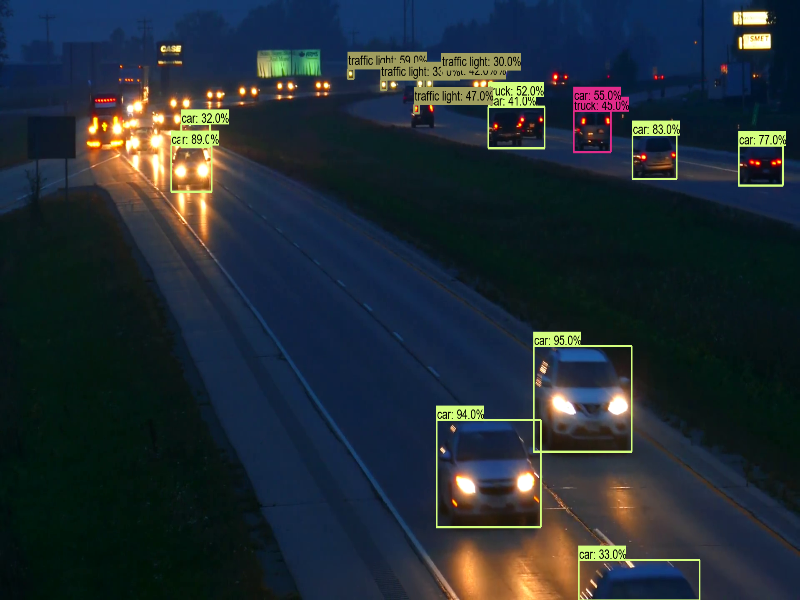

In [ ]:
# plt.show()
from IPython.display import Image
Image('./images_Object_Detection/night.png')